# Separating and Using Functions for Analyzing Color-Mag Diagrams
- first one is from division in I band; looking for change in best-fit slope (and/or correlation coefficient)
- different approaches to identifying loops at bright values
    - find peaks in histogram of residuals from best fit line
    - use changes between points in time; identify pos/pos and neg/neg changes, which don't fit redder when brighter relation
        - use number of points in those quadrants and mean distance from y = -x
    - use slopes from best fit lines to every three (or n) points
        - in SuperOrbitalFeatures, just looking for positive slopes is degenerate with other features
- in the middle: two visualization methods to help with loops and other features
    - add arrows

In [1]:
from uncertainties import ufloat
from uncertainties.umath import *
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.stats import LombScargle
from scipy import signal
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import scipy.optimize
import glob
from astropy.table import Table,join,vstack,unique
from importlib import reload
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sb
import scipy.stats as st
import wotan

import ogle as o #module

blue = 'cornflowerblue'
navy = 'navy'
purple = 'rebeccapurple'
pink = '#CF6275'
maroon = 'maroon'

cross = Table.read('sourcefiles.csv')
full = Table.read('smc_x_m03_zar_match_OGLE_v2.ascii',format='ascii')

In [2]:
summ = pd.read_csv('summtab.csv')
cross['Part'] = 1
cross2 = Table.read('part2files.csv')
cross2 = join(cross2,full,keys='src_n')
cross2['Part'] = 2
allcross = vstack(cross,cross2)

In [3]:
def div_cm(srcn,cross=allcross,interp=[],vband=[],frac=0.5,plot=False,findcorr=False):
    '''Divide color mag by middle of Iint range and fit separately.
    specify fraction of range from faintest point to include in faint piece'''
    #get LCs within function 
    if len(interp)==0:
        #check which part to determine mlist
        row = cross[cross['src_n']==srcn]
        if row['Part']==2:
            mlist = ['OII I','OIII I','OIV I']
        else: 
            mlist = ['OII I','OIII I']
        iband, vband = o.getIV(srcn,cross,stack=True,mlist=mlist,radec=False)
        interp = o.colormag(iband,vband,plot=False)
    #add interpolated I to V table
    vband['I int'] = interp
    #divide into two using interp range
    irange = np.max(interp)-np.min(interp)
    split = np.max(interp) - irange*frac
    #lower interp
    vbright = vband[vband['I int']<=split]
    vfaint = vband[vband['I int']>=split]
    #bright half linear best fit
    bmod = np.polyfit(vbright['V mag'] - vbright['I int'],vbright['I int'],1)
    blinmod = (vbright['V mag'] - vbright['I int'])*bmod[0]+bmod[1]
    #faint part
    fmod = np.polyfit(vfaint['V mag'] - vfaint['I int'],vfaint['I int'],1)
    flinmod = (vfaint['V mag'] - vfaint['I int'])*fmod[0]+fmod[1]
    
    if plot: #plot color-mag with two linear best fits
        plt.scatter(vfaint['V mag'] - vfaint['I int'],vfaint['I int'],color='black',s=4)
        plt.scatter(vbright['V mag'] - vbright['I int'],vbright['I int'],color='maroon',s=4)
        maxi,mini = np.max(interp),np.min(interp)
        plt.ylim(maxi+.01,mini-.01)
        plt.plot(vfaint['V mag'] - vfaint['I int'],flinmod)
        plt.plot(vbright['V mag'] - vbright['I int'],blinmod)
    if not findcorr:
        if np.abs(fmod[0])>np.abs(bmod[0]): print('steeper when fainter')
        elif np.abs(fmod[0])<np.abs(bmod[0]): print('steeper when brighter')
        #returns faint then bright slope
        return fmod[0],bmod[0]
    #find correlation coefficients as another check
    else:
        fcorr = np.corrcoef(vfaint['V mag']-vfaint['I int'],vfaint['I int'])[1][0]
        bcorr = np.corrcoef(vbright['V mag']-vbright['I int'],vbright['I int'])[1][0]
        return (fcorr**2,fmod[0]),(bcorr**2,bmod[0])

In [4]:
mlist1 = ['OII I','OIII I']
mlist2 = ['OII I','OIII I','OIV I']

In [5]:
def histpeaks(hist,diff=2,fracdiff=0.1):
    if fracdiff>0:
        #reset diff based on max height in hist
        maxn = np.max(hist[0])
        diff = fracdiff*maxn
    pkinds = []
    pks = []
    maxn = np.max(hist[0])
    c = 0
    for i in hist[0]:
        #first bin
        if c == 0 and i-hist[0][1]>=diff: nbool = True
        #non-boundary bins
        elif c<len(hist[0])-diff and i-hist[0][c+1]>=diff and i-hist[0][c-1]>=diff: nbool = True
        #final bin
        elif c==len(hist[0])-1 and i-hist[0][c-1]>=diff: nbool = True
        else: nbool = False
        if nbool and i>(np.median(hist[0])):
            pkinds.append(c)
            pks.append(i)
        c+=1
    return pks,pkinds

In [6]:
def colorloop(srcn,fracdiff=0.1,diff=2,close=False,iband=[],vband=[],interp=[]):
    '''Identify if there are loop features in Iint vs. V-I plot using hist of residuals from best fit line'''
    if len(iband)<1 and len(vband)<1 and len(interp)<1:
        try: iband, vband = o.getIV(srcn,cross,stack=True,plot=False,mlist=mlist1)
        except: iband, vband = o.getIV(srcn,cross2,stack=True,plot=False,mlist=mlist2)
        interp = o.colormag(iband,vband,retint=True,both=False,figsize=(7,4))

    #frame with Iint, Vmag, and V-I
    color = pd.DataFrame(columns=['I','V','V-I'])
    color['I'],color['V'],color['V-I'] = interp,vband['V mag'],vband['V mag']-interp
    # get bright frac of Iint
    frac = 0.1
    maxi,mini = np.max(interp),np.min(interp)
    cut = maxi - frac*(maxi-mini)
    brighti = color[color['I']<cut]

    #with large range, better to plot residuals from best fit
    mod = np.polyfit(brighti['V-I'],brighti['I'],1)

    #add residuals from linear model of bright values to df
    brighti['res'] = brighti['I'] - (mod[0]*brighti['V-I'] + mod[1])

    if close:#get histogram values but don't plot
        hist = np.histogram(brighti['res'])
    else:
        plt.figure(figsize=(4,3))
        hist = plt.hist(brighti['res'],color='darkseagreen')
        if len(pks)>=2: 
            print('loops')
            plt.text(np.median(hist[1]),np.max(hist[0])-1,'loops')
        else: 
            print('no loops')
            plt.text(np.median(hist[1]),np.max(hist[0])-1,'no loops')
    #identify histogram peaks
    pks,pkinds = histpeaks(hist,fracdiff=fracdiff,diff=diff)
    return pks,pkinds

In [7]:
def colortime(srcn):
    try: iband, vband = o.getIV(srcn,cross,stack=True,plot=False,mlist=mlist1)
    except: iband, vband = o.getIV(srcn,cross2,stack=True,plot=False,mlist=mlist2)    
    #make color mag diagram
    interp = o.colormag(iband,vband,retint=True,both=False,figsize=(7,4),printcorr=False)

    fig, ax1 = plt.subplots(figsize=(12,4))

    im = ax1.scatter(vband['MJD-50000'],vband['V mag']-interp,color='black',marker='x')
    ax1.set_ylabel('V-I')
    # plt.colorbar(im)
    ax2 = ax1.twinx()
    ax2.set_ylabel('I mag', color=pink); ax2.tick_params(axis='y', labelcolor=pink)
    ax2.scatter(iband['MJD-50000'],iband['I mag'],color=pink,alpha=0.3,s=4)
    # ax2.scatter(vband['MJD-50000'],vband['V mag'],color='darkseagreen',alpha=0.3,s=4)
    maxi,mini = np.max(iband['I mag']),np.min(iband['I mag'])
    ax2.set_ylim(maxi+.02,mini-.02)

    ax1.set_xlabel('MJD-50000')

In [8]:
def carrow(vband,interp,retvect=False,fs=(6,4)):
    '''Add option to first get LCs and interpolated I'''
    vi = vband['V mag']-interp
    plt.figure(figsize=fs)
    plt.scatter(vi,interp,color=pink)
    #vectors
    yvect = interp[1:]-interp[:-1]
    xvect = vi[1:]-vi[:-1]
    plt.quiver(vi[:-1],interp[:-1],xvect,yvect,angles='xy',scale_units='xy',scale=1,color='darkseagreen',alpha=0.5)
    #flip I mag axis
    maxi,mini = np.max(interp),np.min(interp)
    plt.ylim(maxi+.02,mini-.02)
    plt.ylabel('I mag',fontsize=13)
    plt.xlabel('V-I',fontsize=13)
    if retvect: return xvect,yvect

In [9]:
def colorvec(srcn,frac=0.5,plotcm=True,plottext=True,plotquad=True,iband=[],vband=[],interp=[],printall=False,retearly=False):
    if len(iband)<1 and len(vband)<1 and len(interp)<1: #otherwise uses in iband,vband,interp passed in 
        try: iband, vband = o.getIV(srcn,cross,stack=True,plot=False,mlist=mlist1)
        except: iband, vband = o.getIV(srcn,cross2,stack=True,plot=False,mlist=mlist2)
        interp = o.colormag(iband,vband,retint=True,both=False,plot=False,printcorr=False)
    #plot color mag with arrows
    if plotcm:carrow(vband,interp)
    vi = vband['V mag']-interp
    #make df so that can be filtered to just brighter part of color-mag 
    color = pd.DataFrame(columns=['I','V','V-I'])
    color['I'],color['V'],color['V-I'] = interp,vband['V mag'],vi
    maxi,mini = np.max(interp),np.min(interp)
    irange = maxi-mini
    #higher fraction cuts off more
    cut = maxi - frac*irange

    bright = color[color['I']<cut]
    #to also cut out brightest
    # bright = bright[bright['I']>cut2]
    bi = np.array(bright['I'])
    bvi = np.array(bright['V-I'])

    yvect = bi[1:]-bi[:-1]
    xvect = bvi[1:]-bvi[:-1]
    if retearly: return bright,xvect,yvect
    if plotcm: plt.figure(figsize=(5,4))
    if plotquad:
        plt.scatter(xvect,yvect,color='black')
        #dividing quadrants
        plt.axvline(0,color='darkseagreen')
        plt.axhline(0,color='darkseagreen')
        plt.ylabel('I mag change')
        plt.xlabel('V-I mag change')
    #use table to find vectors outside of positive-negative quadrants
    tab = Table({'V-I':xvect,'I mag':yvect})
    #subset of table with both negative
    vineg = tab[tab['V-I']<0]
    neg = vineg[vineg['I mag']<0]
    #subset of table with both positive
    vipos = tab[tab['V-I']>0]
    pos = vipos[vipos['I mag']>0]
    string = f'positive/positive: {len(pos)} \nnegative/negative: {len(neg)}'
    if plottext and plotquad: plt.annotate(string, xy=(0.05, 0.85), xycoords='axes fraction')
    elif printall: print(string)
    #absolute difference from y = -x (checking for points that are barely in this quadrant)
    #changed sum to mean 
    nres = np.mean(np.abs(neg['V-I']+neg['I mag']))
    pres = np.mean(np.abs(pos['V-I']+pos['I mag']))
    string = f'sum of dist from y = -x for pos/pos: {pres:.2f}'
    if plottext and plotquad: plt.annotate(string, xy=(0.15, 0.18), xycoords='axes fraction')
    elif printall: print(string)
    string = f'sum of dist from y = -x for neg/neg: {nres:.2f}'
    if plottext and plotquad: plt.annotate(string, xy=(0.15, 0.12), xycoords='axes fraction')
    elif printall: print(string)
    #returns number of points in two quadrants and mean distance from y = -x
    return len(pos)+len(neg), nres+pres

In [10]:
def colorline(srcn,roll=True,retv=True,hist=True,histcol='darkseagreen',nump=3,frac=0.1,cut=0,printall=True,plotlc=False,plotbr=False,iband=[],vband=[],interp=[]):
    '''Fit a line to every three points (in time) in color-mag
    roll: (bool) Move one point at a time in fit (if False, divide into threes)
    retv: return vband table and slopes rather than just list of slopes
    hist: plot histogram of slopes
    histcol: color for histogram
    TO DO:  delete option to not use roll OR add functionality to brightness check
            add option to look for loops when bluer when brighter'''
    #get I band, V band, and interpolated I
    if len(iband)<1 and len(vband)<1: #if iband,vband not passed in, get LCs
        try: iband, vband = o.getIV(srcn,cross,stack=True,plot=plotlc,mlist=mlist1)
        except: iband, vband = o.getIV(srcn,cross2,stack=True,plot=plotlc,mlist=mlist2)
    if len(interp)<1: interp = o.colormag(iband,vband,retint=True,both=False,plot=plotlc,figsize=(5,4))
    #add interpolated I and V-I to vband table
    vband['I mag'],vband['V-I'] = interp,vband['V mag']-interp
    #loop through in time order and add slopes of best fit to slopes list
    slopes = []
    if roll: loop = np.arange(0,len(vband)-nump)
    #if not roll, don't re-use any points
    else: loop = np.arange(0,len(vband)-nump,nump)
    for v in loop:
        #fit line to point and following two points
        mod = np.polyfit(vband['V-I'][v:v+nump],vband['I mag'][v:v+nump],1)
        #add slope to list of slopes
        slopes.append(mod[0])
    #check whether outlier slopes occur among brightest I band values
    slopes = np.array(slopes)
    #check if redder when brighter (mostly negative slopes)
    if plotbr or printall:
        if len(slopes[slopes<0]) > len(slopes[slopes>0]): 
            #get brightest frac of I band
            maxi, mini = np.max(vband['I mag']),np.min(vband['I mag'])
            #upper bound of I band to be in "bright enough" region
            ub = mini + frac*(maxi-mini) #brightest point + fraction of range
            #get points with positive slopes (or other cutoff)
            pos_slopes = np.where(slopes>cut)
            if printall: print(slopes[pos_slopes])
            #check if those points are at bright I mag
            ifr = vband[pos_slopes]
            imags = ifr['I mag']
            #find number of positive slopes at bright values
            bright = ifr[ifr['I mag']<ub]
            #print the following string for each point at bright values
            if printall: print('turnaround on bright values \n'*len(bright))
            #plot
            if plotbr:
                plt.figure(figsize=(5,3))
                plt.scatter(bright['MJD-50000'],bright['I mag'],c=bright['V-I'],cmap='plasma')
                plt.colorbar(label='V-I')
                plt.ylabel('I mag');plt.xlabel('MJD-50000')
                plt.ylim(np.max(bright['I mag'])+.02,np.min(bright['I mag'])-.02)
    #probably integrate the else above by just having option to SWITCH THE SIGNS
    
    #histogram of slopes
    if hist: plt.figure(figsize=(4,3)); a = sb.distplot(slopes,color=histcol,kde=False); plt.xlabel('color-mag slopes')
    if retv: return vband, slopes
    else: return slopes

In [11]:
srcns = np.concatenate([np.array(cross['src_n']),np.array(cross2['src_n'])])
from matplotlib import colors as mcolors

In [12]:
import warnings
warnings.filterwarnings("ignore")

new function using vectors: plot vectors vs. time to look for loop behavior rather than erratic changes

### residuals as a function of brightness
- perhaps high scatter can be identified by ~even residuals whereas loops have higher residuals at brighter values

In [189]:
def mono_count(bdf,divide=True):
    '''Count how many points in residuals of bright df are following monotonic trends
    generalized by not first identifying peaks
    divide: divide number of monotonic by total number of points'''
    #try to quantify loopiness by counting how many points before and after peaks are monotonic
    num_mon = 0 #counter for monotonic
    i = 0 #begin with first point
    #repeat for points after peak
    while i+2 < len(bdf['residual']):
        sub = 2
        mono = True
        while mono and i+sub<len(bdf['residual']):
            mono = o.monotonic(bdf['residual'][i:i+sub])
            sub+=1
        #add to num_mon based on what sub left off on; it automatically gets to 3
        num_mon += sub-3 #adds nothing if there aren't three montonic points

        #now reset i to i+sub to start again
        i += sub-2 #adds 1 if no monotonic behavior
    if divide: return num_mon/len(bdf)
    return num_mon

In [191]:
def res_brightness(srcn,frac=0.5,iband=[],vband=[],interp=[],plot=False,plotres=False,plotrestime=False,printall=True,retdf=False,retmono=True):
    '''Fit line to brightest half and faintest half of points and compare residuals from those lines
    retmono: include fraction of points in residual vs. time of bright part of color-mag that are changing monotonically'''
    if len(iband)<1 and len(vband)<1 and len(interp)<1:
        try: iband, vband = o.getIV(srcn,cross,stack=True,plot=plot,mlist=mlist1)
        except: iband, vband = o.getIV(srcn,cross2,stack=True,plot=plot,mlist=mlist2)
        interp = o.colormag(iband,vband,retint=True,both=False,figsize=(7,4),printcorr=False)
        if not plot: plt.close()

    #frame with Iint, Vmag, and V-I
    color = pd.DataFrame(columns=['day','I','V','V-I','residual'])
    color['I'],color['V'],color['V-I'] = interp,vband['V mag'],vband['V mag']-interp
    color['day'] = vband['MJD-50000']
    
    maxi,mini = np.max(interp),np.min(interp)
    #cutoff measured from max (faint), so large frac yields smaller bright frame
    bright = color[color['I']<(maxi-(maxi-mini)*frac)]
    faint = color[color['I']>(maxi-(maxi-mini)*frac)]

    #fit line to I vs. V-I for bright and faint values
    bmod = np.polyfit(bright['V-I'],bright['I'],1)
    fmod = np.polyfit(faint['V-I'],faint['I'],1)
    
    #expected values using linear fit
    expectb = bright['V-I']*bmod[0] + bmod[1]
    expectf = faint['V-I']*fmod[0] + fmod[1]
    
    #find residuals from best fit -- preserve sign
    bright['residual'] = bright['I'] - expectb
    faint['residual'] = faint['I'] - expectf
    
    #plot residual vs. I mag
    if plotres:
        plt.figure(figsize=(8,5))
        mind,maxd = np.min(color['day']),np.max(color['day'])
        plt.scatter(bright['I'],bright['residual'],c=bright['day'],cmap='plasma',vmin=mind,vmax=maxd)
        plt.scatter(faint['I'],faint['residual'],c=faint['day'],cmap='plasma',vmin=mind,vmax=maxd)
        plt.colorbar(label='MJD-50000')
        plt.ylabel('I mag - expected I mag',fontsize=13)
        plt.xlabel('I mag',fontsize=13)
        plt.xlim(maxi+.02,mini-.02)
        
    #plot residual vs. time
    if plotrestime:   
        plt.figure(figsize=(8,5))
        plt.scatter(bright['day'],bright['residual'],c=bright['I'],cmap='plasma')
        plt.ylabel('I mag - expected I mag',fontsize=13)
        plt.xlabel('Day')
        plt.colorbar(label='I mag')
        
    #return tables
    if retdf: return bright
    #sum of abs value over total number of points
    #changed from sum of squares to make values larger
    bsum = np.sum(np.abs(bright['residual']))/len(bright)
    fsum = np.sum(np.abs(faint['residual']))/len(faint)
    if printall: 
        print(f'faint sum of abs residuals: {fsum}')
        print(f'bright sum of abs residuals: {bsum}')
        
    #fit line to bright residuals vs. I mag
    resmod = np.polyfit(bright['I'],bright['residual'],1)
    fresmod = np.polyfit(faint['I'],faint['residual'],1)
    
    if retmono: 
        mono_frac = mono_count(bright,divide=True)
        return bsum,fsum,resmod[0]-fresmod[0],mono_frac
    return bsum,fsum,resmod[0]-fresmod[0] #bright sum of residuals, faint sum of residuals, and difference between slopes in res vs. I mag plot

faint sum of abs residuals: 0.04838612282268458
bright sum of abs residuals: 0.09942609550728602
faint sum of abs residuals: 0.02186586084307213
bright sum of abs residuals: 0.059969469305394534


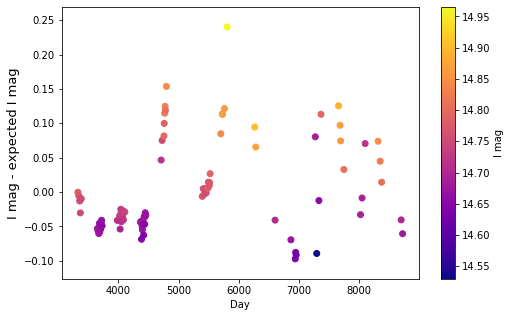

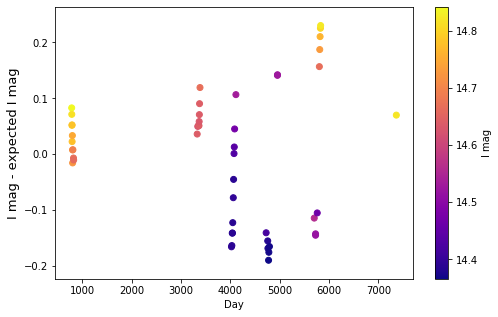

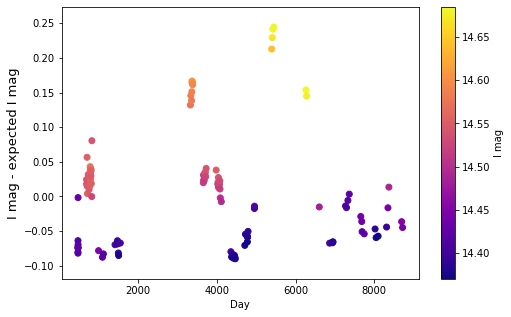

In [192]:
sums = res_brightness(3,plot=False,plotrestime=True,retdf=True)
sums = res_brightness(15,plot=False,plotrestime=True)
sums = res_brightness(16,plot=False,plotrestime=True)

In [ ]:
# leaving old code mono counter here for now
#     num_mon = 0 #counter for monotonic
#     for p in peaks:
#         #loop thru points before
#         sub = 2 #value to subtract to start
#         mono = True
#         while mono:
#             #reset bool mono based on whether or not it's still monotonic
#             mono = o.monotonic(bdf['residual'][p-sub:p])
#             sub+=1
#         #add to num_mon based on what sub left off on; it automatically gets to 3
#         num_mon += sub-3

#         #repeat for points after peak
#         sub = 2
#         mono = True
#         while mono and p+sub<len(bdf['residual']):
#             mono = o.monotonic(bdf['residual'][p:p+sub])
#             sub+=1
#         #add to num_mon based on what sub left off on; it automatically gets to 3
#         num_mon += sub-3
#     if divide: return num_mon/len(bdf)
#     return num_mon

doesn't need to be repeated (so commented out), but added mean residual to summ tab
- once this method done, decide what other residual/loop info to add

In [105]:
#add color-mag residuals to summ tab
# summ['abs mean I vs. V-I residual'] = np.zeros(len(summ))

In [115]:
# means = []
# for s in srcns: 
#     try: 
#         try: iband, vband = o.getIV(s,cross,stack=True,plot=False,mlist=mlist1)
#         except: iband, vband = o.getIV(s,cross2,stack=True,plot=False,mlist=mlist2)
#         interp = o.colormag(iband,vband,retint=True,both=False,figsize=(7,4),printcorr=False)
#         plt.close()
#         #linear best fit to color-mag
#         mod = np.polyfit(vband['V mag']-interp,interp,1)
#         #predicted I mag based on linear best fit
#         expecti = (vband['V mag']-interp)*mod[0] + mod[1]
#         #calculate residuals
#         residuals = interp - expecti
#         #mean residual abs value
#         mean_res = np.mean(np.abs(residuals))
#         #add to list before adding to table
#         means.append(mean_res)
#     except: 
#         #add nan to list
#         means.append(np.nan)
#         print(f'source {s} not found')   

empty file for OIII I
source 51 not found
empty file for OIII I
source 1 not found
empty file for OII I
empty file for OIII I


In [119]:
# summ['abs mean I vs. V-I residual'] = means

In [120]:
# summ.to_csv('summtab.csv',index=False)

In [193]:
#further test by making list of loop sources and list of scatter sources, and then look at residual results for each
loops = [3,15,16,13,27,46,125,80,86,87,132,128,24]
scatter = [36,58,59,5,30,21,22,64,54,62,60,61,71,72,73,68,69,76,81,84,85,96,111,133]
other = [35,44,50,98,101,121,115,116] #other weird sources
lfsum,lbsum,sfsum,sbsum,ofsum,obsum = [],[],[],[],[],[]
#lists for slopes in residual vs. I mag for bright points
lslopes,sslopes,oslopes = [],[],[]
#fraction of points in residual vs. time that are in monotonic trend (hypothesis is that it's higher for loop sources)
lmfrac,smfrac,omfrac = [],[],[]
for l in loops:
    b,f,bslope,mfrac = res_brightness(l,plot=False,printall=False,frac=0.5)
    lfsum.append(f);lbsum.append(b);lslopes.append(bslope)
    lmfrac.append(mfrac)
for s in scatter:
    b,f,bslope,mfrac = res_brightness(s,plot=False,printall=False,frac=0.5)
    sfsum.append(f);sbsum.append(b);sslopes.append(bslope)
    smfrac.append(mfrac)
for i in other:
    b,f,bslope,mfrac = res_brightness(i,plot=False,printall=False,frac=0.5)
    ofsum.append(f);obsum.append(b);oslopes.append(bslope) 
    omfrac.append(mfrac)

Text(0.5, 0, 'Sum of Faint Residuals')

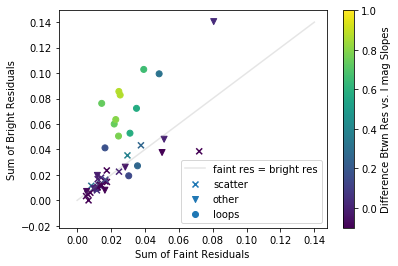

In [194]:
plt.scatter(sfsum,sbsum,marker='x',label='scatter',c=sslopes,vmin=-.1,vmax=1)
plt.scatter(ofsum,obsum,marker='v',label='other',c=oslopes,vmin=-.1,vmax=1)
plt.scatter(lfsum,lbsum,label='loops',c=lslopes,vmin=-.1,vmax=1)
plt.colorbar(label='Difference Btwn Res vs. I mag Slopes')

x = np.linspace(0,.14)
plt.plot(x,x,color='grey',alpha=0.2,label='faint res = bright res')
plt.legend()
plt.ylabel('Sum of Bright Residuals')
plt.xlabel('Sum of Faint Residuals')

the slopes and monotonic fractions are both potentially helpful
- so now have four helpful dimensions for separating loopy sources
- may be worth throwing into a PCA

In [212]:
#divide bsum by fsum to collapse dimensions
sdiv = np.array(sbsum)/sfsum #subtraction also works decently
ldiv = np.array(lbsum)/lfsum
odiv = np.array(obsum)/ofsum

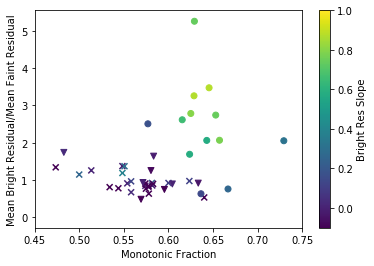

In [218]:
plt.scatter(smfrac,sdiv,marker='x',label='scatter',c=sslopes,vmin=-.1,vmax=1)
plt.scatter(omfrac,odiv,marker='v',label='other',c=oslopes,vmin=-.1,vmax=1)
plt.scatter(lmfrac,ldiv,label='loops',c=lslopes,vmin=-.1,vmax=1)
#cutting out outlier
plt.xlim(0.45,0.75)
plt.colorbar(label='Bright Res Slope')
plt.ylabel('Mean Bright Residual/Mean Faint Residual')
plt.xlabel('Monotonic Fraction')
# plt.savefig('Figs/resfrac_monfrac.png',dpi=150,bbox_inches='tight')

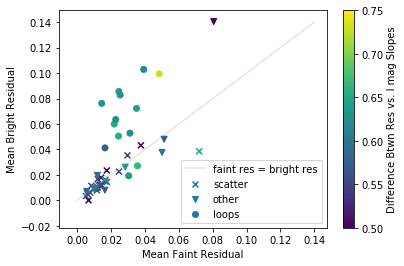

In [219]:
plt.scatter(sfsum,sbsum,marker='x',label='scatter',c=smfrac,vmin=0.5,vmax=0.75)
plt.scatter(ofsum,obsum,marker='v',label='other',c=omfrac,vmin=0.5,vmax=0.75)
plt.scatter(lfsum,lbsum,label='loops',c=lmfrac,vmin=0.5,vmax=0.75)
plt.colorbar(label='Difference Btwn Res vs. I mag Slopes')

x = np.linspace(0,.14)
plt.plot(x,x,color='grey',alpha=0.2,label='faint res = bright res')
plt.legend()
plt.ylabel('Mean Bright Residual')
plt.xlabel('Mean Faint Residual')

# plt.savefig('Figs/bright_faint_slopediff.png',dpi=150,bbox_inches='tight')

Text(0.5, 0, 'Mean Faint Residual')

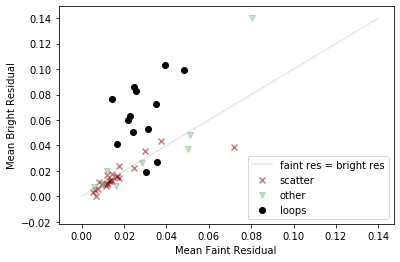

In [217]:
plt.scatter(sfsum,sbsum,color='maroon',marker='x',label='scatter',alpha=0.5)
plt.scatter(ofsum,obsum,color='darkseagreen',marker='v',label='other',alpha=0.5)
plt.scatter(lfsum,lbsum,color='black',label='loops')


x = np.linspace(0,.14)
plt.plot(x,x,color='grey',alpha=0.2,label='faint res = bright res')
plt.legend()
plt.ylabel('Mean Bright Residual')
plt.xlabel('Mean Faint Residual')


#### for loops, want dip with color ~black (bright)

I and V-I correlation: -0.8002922261337712
V and V-I correlation: -0.6698593996852642


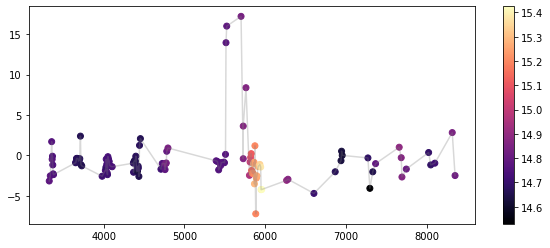

In [85]:
#start outside of function
vband,slopes = colorline(3,roll=True,retv=True,hist=False,histcol='darkseagreen',nump=3,frac=0.1,cut=0,printall=False,plotlc=False,plotbr=False,iband=[],vband=[],interp=[])
plt.figure(figsize=(10,4))

plt.scatter(vband['MJD-50000'][:-3],slopes,c=vband['I mag'][:-3],cmap='magma')
plt.colorbar()
plt.plot(vband['MJD-50000'][:-3],slopes,color='grey',alpha=0.3)


I and V-I correlation: -0.28392614544546685
V and V-I correlation: 0.1227097449647219


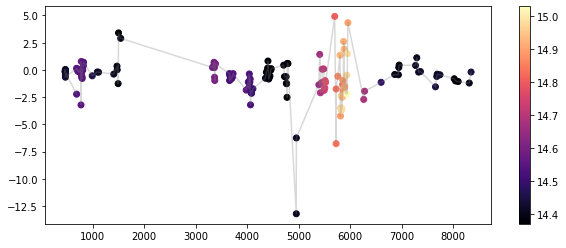

In [84]:
#start outside of function
vband,slopes = colorline(16,roll=True,retv=True,hist=False,histcol='darkseagreen',nump=3,frac=0.1,cut=0,printall=False,plotlc=False,plotbr=False,iband=[],vband=[],interp=[])
plt.figure(figsize=(10,4))

plt.scatter(vband['MJD-50000'][:-3],slopes,c=vband['I mag'][:-3],cmap='magma')
plt.colorbar()
plt.plot(vband['MJD-50000'][:-3],slopes,color='grey',alpha=0.3)


I and V-I correlation: -0.9222358982634402
V and V-I correlation: -0.8022991122992864
I and V-I correlation: -0.9372414483256165
V and V-I correlation: -0.8515095648198383


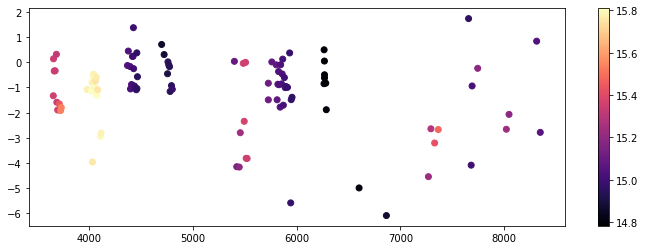

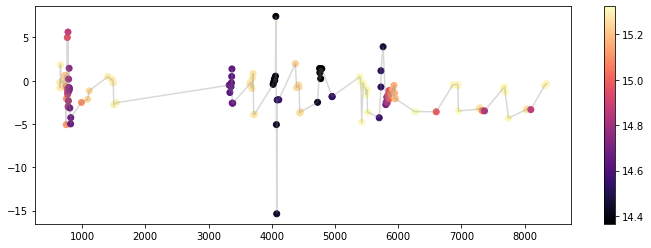

In [83]:
plt.figure(figsize=(12,4))
vband,slopes = colorline(13,roll=True,retv=True,hist=False,histcol='darkseagreen',nump=3,frac=0.1,cut=0,printall=False,plotlc=False,plotbr=False,iband=[],vband=[],interp=[])
plt.scatter(vband['MJD-50000'][:-3],slopes,c=vband['I mag'][:-3],cmap='magma')
plt.colorbar()
vband,slopes = colorline(15,roll=True,retv=True,hist=False,histcol='darkseagreen',nump=3,frac=0.1,cut=0,printall=False,plotlc=False,plotbr=False,iband=[],vband=[],interp=[])
plt.figure(figsize=(12,4))
plt.scatter(vband['MJD-50000'][:-3],slopes,c=vband['I mag'][:-3],cmap='magma')
plt.colorbar()
plt.plot(vband['MJD-50000'][:-3],slopes,color='grey',alpha=0.3)


I and V-I correlation: -0.9086555042418574
V and V-I correlation: -0.7772043187778405
I and V-I correlation: -0.8678520855167449
V and V-I correlation: -0.7253066994414351


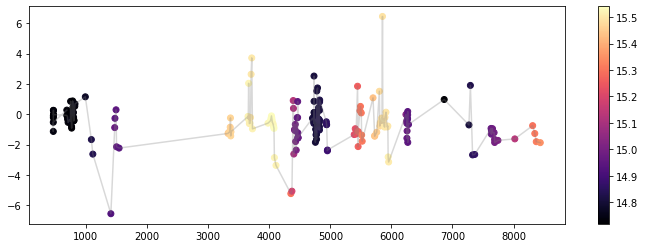

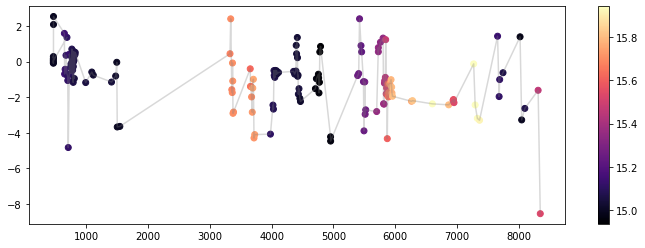

In [82]:
vband,slopes = colorline(27,roll=True,retv=True,hist=False,histcol='darkseagreen',nump=3,frac=0.1,cut=0,printall=False,plotlc=False,plotbr=False,iband=[],vband=[],interp=[])
plt.figure(figsize=(12,4))
plt.scatter(vband['MJD-50000'][:-3],slopes,c=vband['I mag'][:-3],cmap='magma')
plt.colorbar()
plt.plot(vband['MJD-50000'][:-3],slopes,color='grey',alpha=0.3)


vband,slopes = colorline(46,roll=True,retv=True,hist=False,histcol='darkseagreen',nump=3,frac=0.1,cut=0,printall=False,plotlc=False,plotbr=False,iband=[],vband=[],interp=[])
plt.figure(figsize=(12,4))
plt.scatter(vband['MJD-50000'][:-3],slopes,c=vband['I mag'][:-3],cmap='magma')
plt.colorbar()
plt.plot(vband['MJD-50000'][:-3],slopes,color='grey',alpha=0.3)


I and V-I correlation: -0.6957365004457309
V and V-I correlation: 0.6189396891999773
I and V-I correlation: -0.8744251563223343
V and V-I correlation: -0.7590429450237982


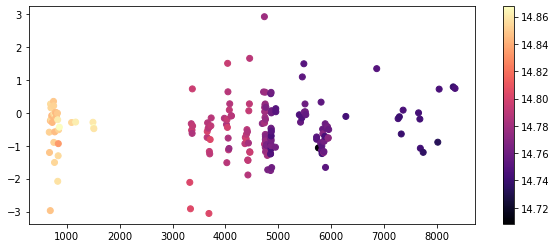

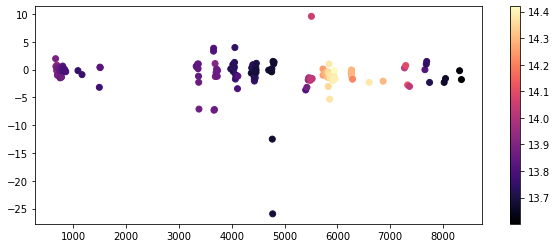

In [34]:
vband,slopes = colorline(38,roll=True,retv=True,hist=False,histcol='darkseagreen',nump=3,frac=0.1,cut=0,printall=False,plotlc=False,plotbr=False,iband=[],vband=[],interp=[])
plt.figure(figsize=(10,4))
plt.scatter(vband['MJD-50000'][:-3],slopes,c=vband['I mag'][:-3],cmap='magma')
plt.colorbar()

vband,slopes = colorline(125,roll=True,retv=True,hist=False,histcol='darkseagreen',nump=3,frac=0.1,cut=0,printall=False,plotlc=False,plotbr=False,iband=[],vband=[],interp=[])
plt.figure(figsize=(10,4))
plt.scatter(vband['MJD-50000'][:-3],slopes,c=vband['I mag'][:-3],cmap='magma')
plt.colorbar()

#### repeat with vectors rather than 3-point slopes

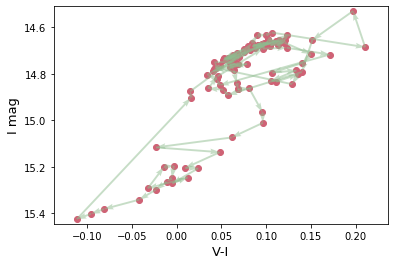

In [79]:
bright,xvect,yvect = colorvec(3,frac=0.1,plotcm=True,plottext=True,plotquad=True,iband=[],vband=[],interp=[],printall=False,retearly=True)

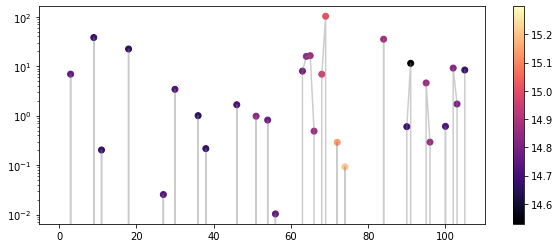

In [81]:
#positive are loops
plt.figure(figsize=(10,4))
# vects = np.sqrt(xvect**2+yvect**2)
vects = yvect/xvect
plt.scatter(np.arange(len(bright)-1),vects,c=bright['I'][1:],cmap='magma')
plt.plot(np.arange(len(bright)-1),vects,color='grey',alpha=0.4)

plt.colorbar()
plt.yscale('log')


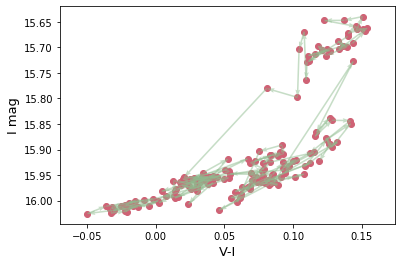

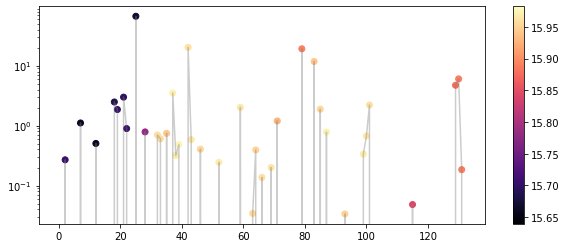

In [76]:
bright,xvect,yvect = colorvec(6,frac=0.1,plotcm=True,plottext=True,plotquad=True,iband=[],vband=[],interp=[],printall=False,retearly=True)
#positive are loops
plt.figure(figsize=(10,4))
# vects = np.sqrt(xvect**2+yvect**2)
vects = yvect/xvect
plt.scatter(np.arange(len(bright)-1),vects,c=bright['I'][1:],cmap='magma')
plt.plot(np.arange(len(bright)-1),vects,color='grey',alpha=0.4)

plt.colorbar()
plt.yscale('log')


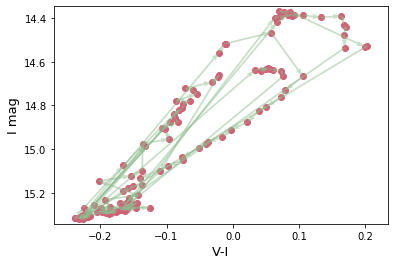

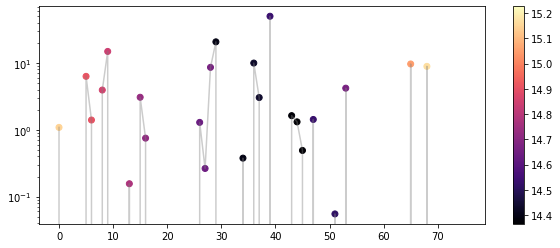

In [75]:
bright,xvect,yvect = colorvec(15,frac=0.1,plotcm=True,plottext=True,plotquad=True,iband=[],vband=[],interp=[],printall=False,retearly=True)
#positive are loops
plt.figure(figsize=(10,4))
# vects = np.sqrt(xvect**2+yvect**2)
vects = yvect/xvect
plt.scatter(np.arange(len(bright)-1),vects,c=bright['I'][1:],cmap='magma')
plt.plot(np.arange(len(bright)-1),vects,color='grey',alpha=0.4)

plt.colorbar()
plt.yscale('log')


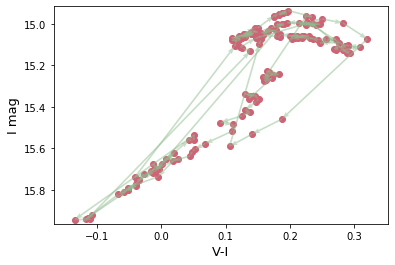

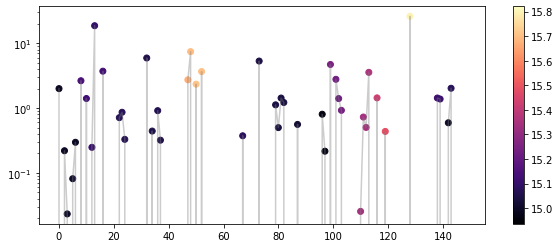

In [74]:
bright,xvect,yvect = colorvec(46,frac=0.1,plotcm=True,plottext=True,plotquad=True,iband=[],vband=[],interp=[],printall=False,retearly=True)
#positive are loops
plt.figure(figsize=(10,4))
# vects = np.sqrt(xvect**2+yvect**2)
vects = yvect/xvect
plt.scatter(np.arange(len(bright)-1),vects,c=bright['I'][1:],cmap='magma')
plt.plot(np.arange(len(bright)-1),vects,color='grey',alpha=0.4)

plt.colorbar()
plt.yscale('log')


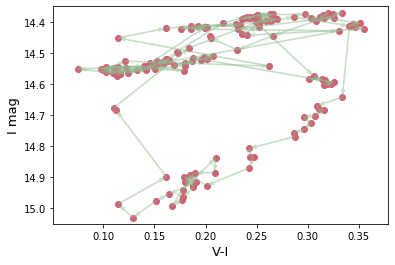

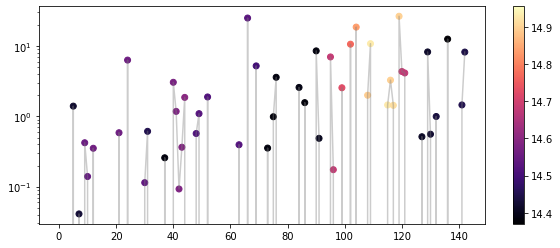

In [73]:
bright,xvect,yvect = colorvec(16,frac=0.1,plotcm=True,plottext=True,plotquad=True,iband=[],vband=[],interp=[],printall=False,retearly=True)
#positive are loops
plt.figure(figsize=(10,4))
# vects = np.sqrt(xvect**2+yvect**2)
vects = yvect/xvect
plt.scatter(np.arange(len(bright)-1),vects,c=bright['I'][1:],cmap='magma')
plt.plot(np.arange(len(bright)-1),vects,color='grey',alpha=0.4)

plt.colorbar()
plt.yscale('log')


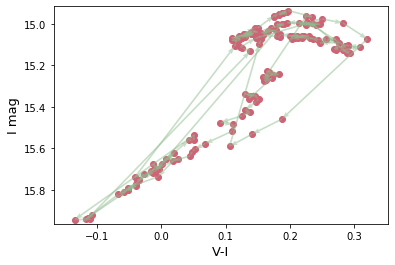

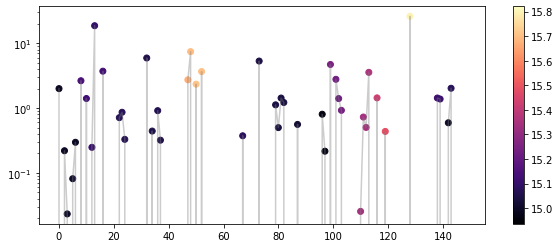

In [72]:
bright,xvect,yvect = colorvec(46,frac=0.1,plotcm=True,plottext=True,plotquad=True,iband=[],vband=[],interp=[],printall=False,retearly=True)
#positive are loops
plt.figure(figsize=(10,4))
# vects = np.sqrt(xvect**2+yvect**2)
vects = yvect/xvect
plt.scatter(np.arange(len(bright)-1),vects,c=bright['I'][1:],cmap='magma')
plt.plot(np.arange(len(bright)-1),vects,color='grey',alpha=0.4)

plt.colorbar()
plt.yscale('log')


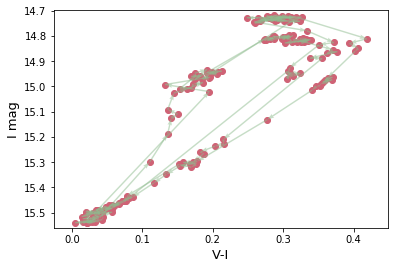

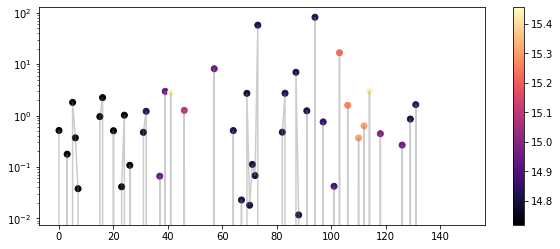

In [71]:
bright,xvect,yvect = colorvec(27,frac=0.1,plotcm=True,plottext=True,plotquad=True,iband=[],vband=[],interp=[],printall=False,retearly=True)
#positive are loops
plt.figure(figsize=(10,4))
# vects = np.sqrt(xvect**2+yvect**2)
vects = yvect/xvect
plt.scatter(np.arange(len(bright)-1),vects,c=bright['I'][1:],cmap='magma')
plt.plot(np.arange(len(bright)-1),vects,color='grey',alpha=0.4)

plt.colorbar()
#log makes it easier to see if neighbors have similar behavior/correlated
plt.yscale('log')


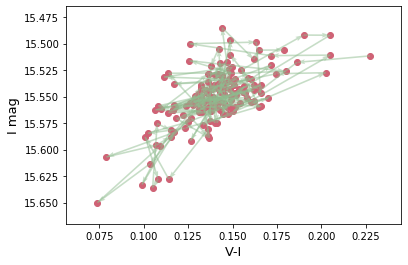

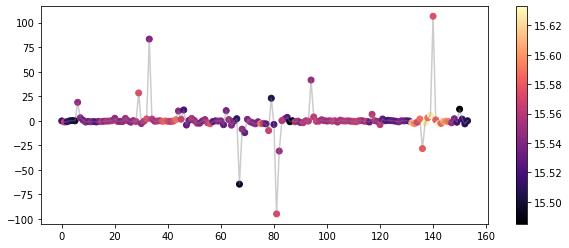

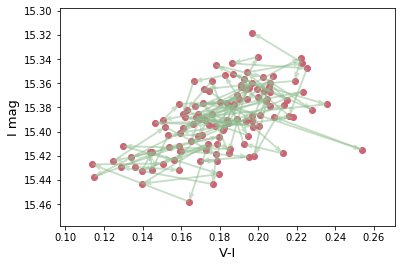

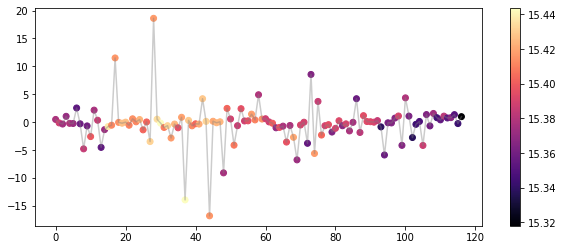

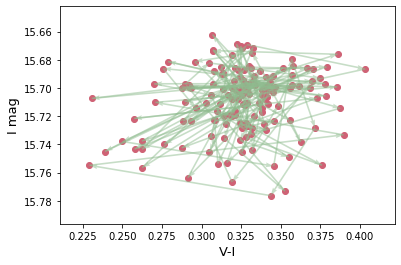

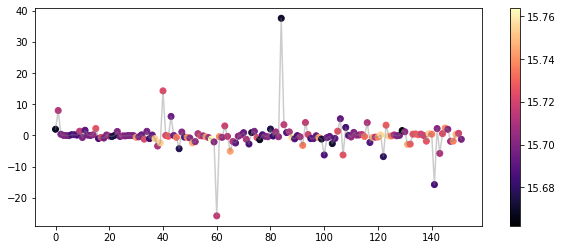

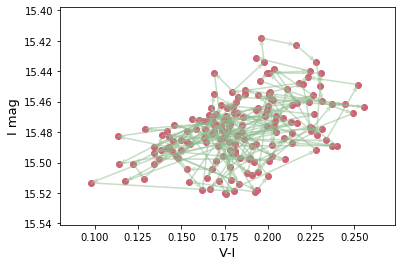

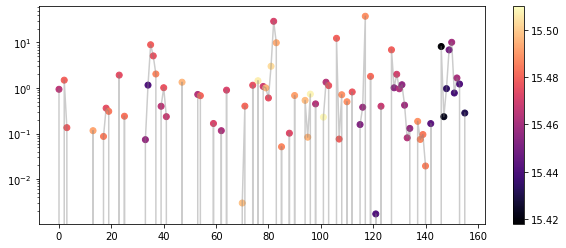

In [70]:
#compare to a couple with high scatter but looks like no loops (but are there?)
bright,xvect,yvect = colorvec(5,frac=0.1,plotcm=True,plottext=True,plotquad=True,iband=[],vband=[],interp=[],printall=False,retearly=True)
#positive are loops
plt.figure(figsize=(10,4))
# vects = np.sqrt(xvect**2+yvect**2)
vects = yvect/xvect
plt.scatter(np.arange(len(bright)-1),vects,c=bright['I'][1:],cmap='magma')
plt.plot(np.arange(len(bright)-1),vects,color='grey',alpha=0.4)

plt.colorbar()

bright,xvect,yvect = colorvec(36,frac=0.1,plotcm=True,plottext=True,plotquad=True,iband=[],vband=[],interp=[],printall=False,retearly=True)
#positive are loops
plt.figure(figsize=(10,4))
# vects = np.sqrt(xvect**2+yvect**2)
vects = yvect/xvect
plt.scatter(np.arange(len(bright)-1),vects,c=bright['I'][1:],cmap='magma')
plt.plot(np.arange(len(bright)-1),vects,color='grey',alpha=0.4)

plt.colorbar()

bright,xvect,yvect = colorvec(58,frac=0.1,plotcm=True,plottext=True,plotquad=True,iband=[],vband=[],interp=[],printall=False,retearly=True)
#positive are loops
plt.figure(figsize=(10,4))
# vects = np.sqrt(xvect**2+yvect**2)
vects = yvect/xvect
plt.scatter(np.arange(len(bright)-1),vects,c=bright['I'][1:],cmap='magma')
plt.plot(np.arange(len(bright)-1),vects,color='grey',alpha=0.4)

plt.colorbar()

bright,xvect,yvect = colorvec(59,frac=0.1,plotcm=True,plottext=True,plotquad=True,iband=[],vband=[],interp=[],printall=False,retearly=True)
#positive are loops
plt.figure(figsize=(10,4))
# vects = np.sqrt(xvect**2+yvect**2)
vects = yvect/xvect
plt.scatter(np.arange(len(bright)-1),vects,c=bright['I'][1:],cmap='magma')
plt.plot(np.arange(len(bright)-1),vects,color='grey',alpha=0.4)
plt.yscale('log')
plt.colorbar()

#### these methods don't *look* super promising, but can try saving the outlier magnitude (or as fraction of min or max); slope, and somehow neighbor info
- problem is that there don't appear to be enough neighbor loops

using first 20 sources passed in 


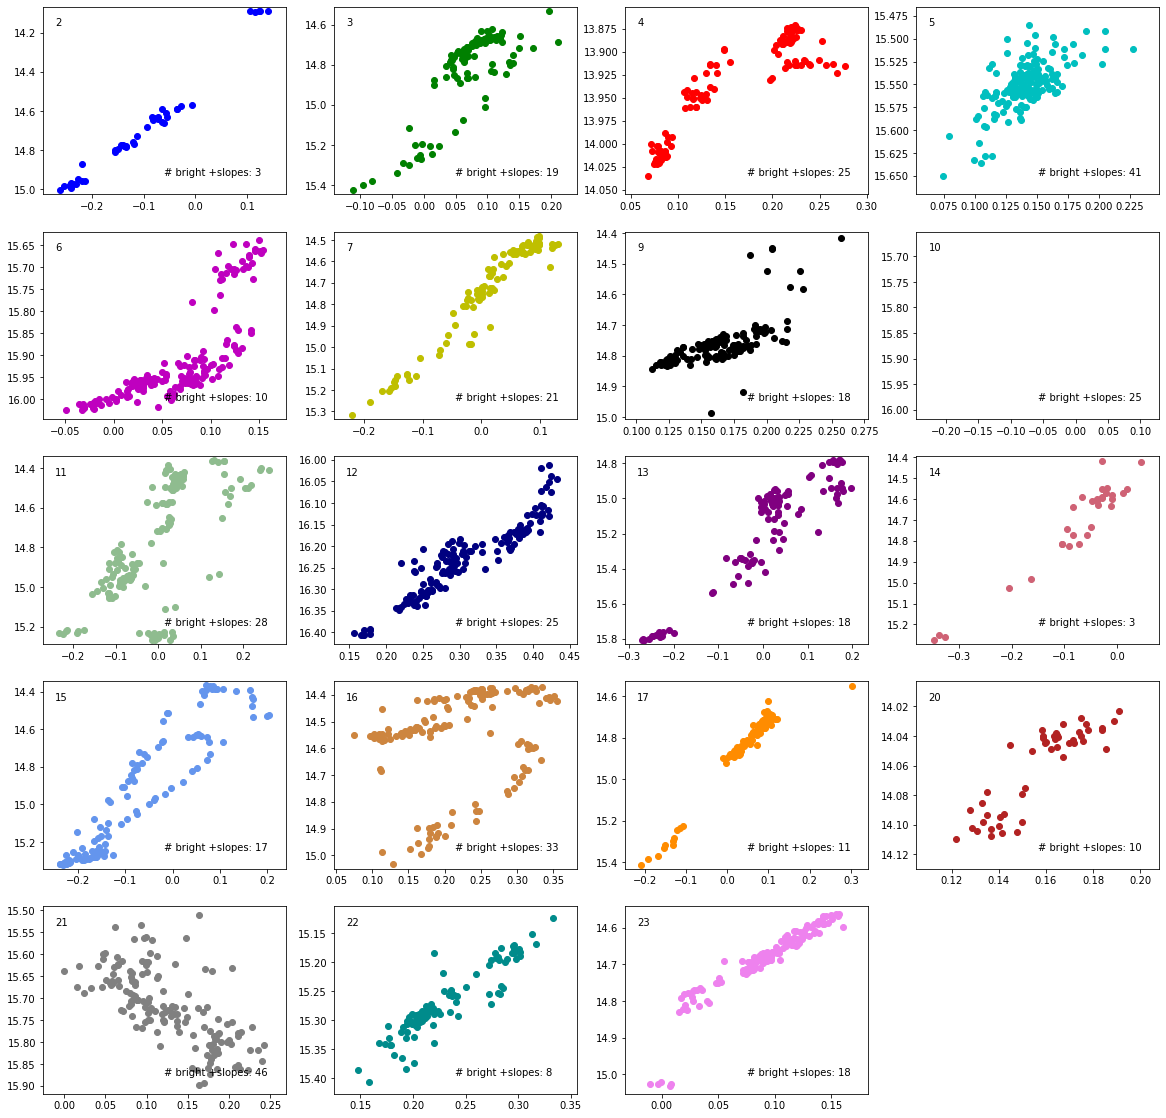

posx and posy should be finite values
posx and posy should be finite values


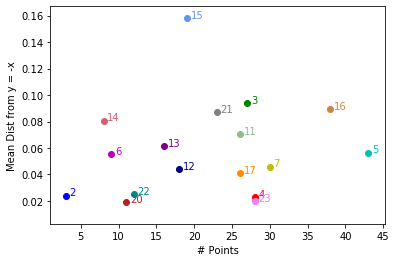

In [18]:
def check_quad(sources):
    '''plots color-mag subplots and mean dist vs. #points fig for up to 20 sources
    sources: source numbers to display
    TO DO: add results from other methods as well'''
    #take first 20 sources if too many passed in
    if len(sources)>20: 
        sources = sources[:20]
        print('using first 20 sources passed in ')
    ocolors = ['darkseagreen','navy','purple',pink,'cornflowerblue','peru','darkorange','firebrick',
              'grey','darkcyan','violet','palegreen','lightsalmon']
    allcols = list(mcolors.BASE_COLORS.keys()) + ocolors
    #initiate lists
    points,dists = [],[]
    fig = plt.figure(figsize=(20,20))
    for s in range(1,len(sources)): #first 20 sources
        ax = fig.add_subplot(5,4,s)
        color = allcols[s-1]
        #get LC 
        try: iband, vband = o.getIV(sources[s-1],cross,stack=True,plot=False,mlist=mlist1)
        except: iband, vband = o.getIV(sources[s-1],cross2,stack=True,plot=False,mlist=mlist2)
        interp = o.colormag(iband,vband,retint=True,both=False,plot=False,printcorr=False)
        #plot colormag
        ax.scatter(vband['V mag']-interp,interp,color=color)
        #annotate with source number
        plt.annotate(str(sources[s-1]), xy=(0.05, 0.9), xycoords='axes fraction')
        #flip y-axis
        maxi,mini = np.max(interp),np.min(interp)
        ax.set_ylim(maxi+.02,mini-.02)
        #get vectors
        npoint, dist = colorvec(sources[s-1],frac=0.5,plotcm=False,plottext=False,plotquad=False,iband=iband,vband=vband,interp=interp)
        points.append(npoint);dists.append(dist)
        #do colorline (fits lines to every three points)
        slopes = colorline(sources[s-1],roll=True,retv=False,hist=False,nump=3,frac=0.1,cut=0,printall=False,plotlc=False,plotbr=False,iband=iband,vband=vband,interp=interp)
        #get positive slopes (bluer when brighter)
        pos_slopes = np.where(slopes>0)
        #get I values for pos slopes
        imags = interp[pos_slopes]
        #include pos slopes that are in brightest quarter 
        irange = maxi-mini
        numpos = len(imags[imags<mini+0.75*irange])
        ax.annotate(f'# bright +slopes: {numpos}',xy=(0.5, 0.1), xycoords='axes fraction')
        #look for loops uisng histogram of residuals from best fit line
        
        #wasn't working well -- occasional error and not giving desired result
        pk,pkind = colorloop(sources[s-1],fracdiff=0.2,diff=2,close=True,iband=iband,vband=vband,interp=interp)
        #annotate based on if there are at least peaks in hist
#         if len(pk)>=2:
#             ax.annotate(f'loop',xy=(0.5, 0.2), xycoords='axes fraction')
#         else: ax.annotate(f'no loop found',xy=(0.5, 0.2), xycoords='axes fraction')
            
    #plot all on new figure
    fig = plt.figure()
    for i in range(len(points)):
        plt.scatter(points[i],dists[i],color=allcols[i])
        #also annotate with srcn
        plt.text(points[i]+0.5,dists[i],str(sources[i]),color=allcols[i])
    plt.xlabel('# Points')
    plt.ylabel('Mean Dist from y = -x') #currently really the sum of mean dists for two quadrants
    return
check_quad(srcns[:23])

**notice source 5 is gets high #points with pos/pos and #points with pos slope at bright values (similar)**
- tried a bit already, but any better way to identify *continuous* rotation?
#### list of loops -- revisit with arrows
- 3

#### potential loops
- 13,4,6 (and these don't stick out on plot very well)
    - these would do better with just looking for higher spread at brighter values
    
#### list of other strange sources to revisit with arrows
- 11,16 (are these "loops"?), 

empty file for OIII I


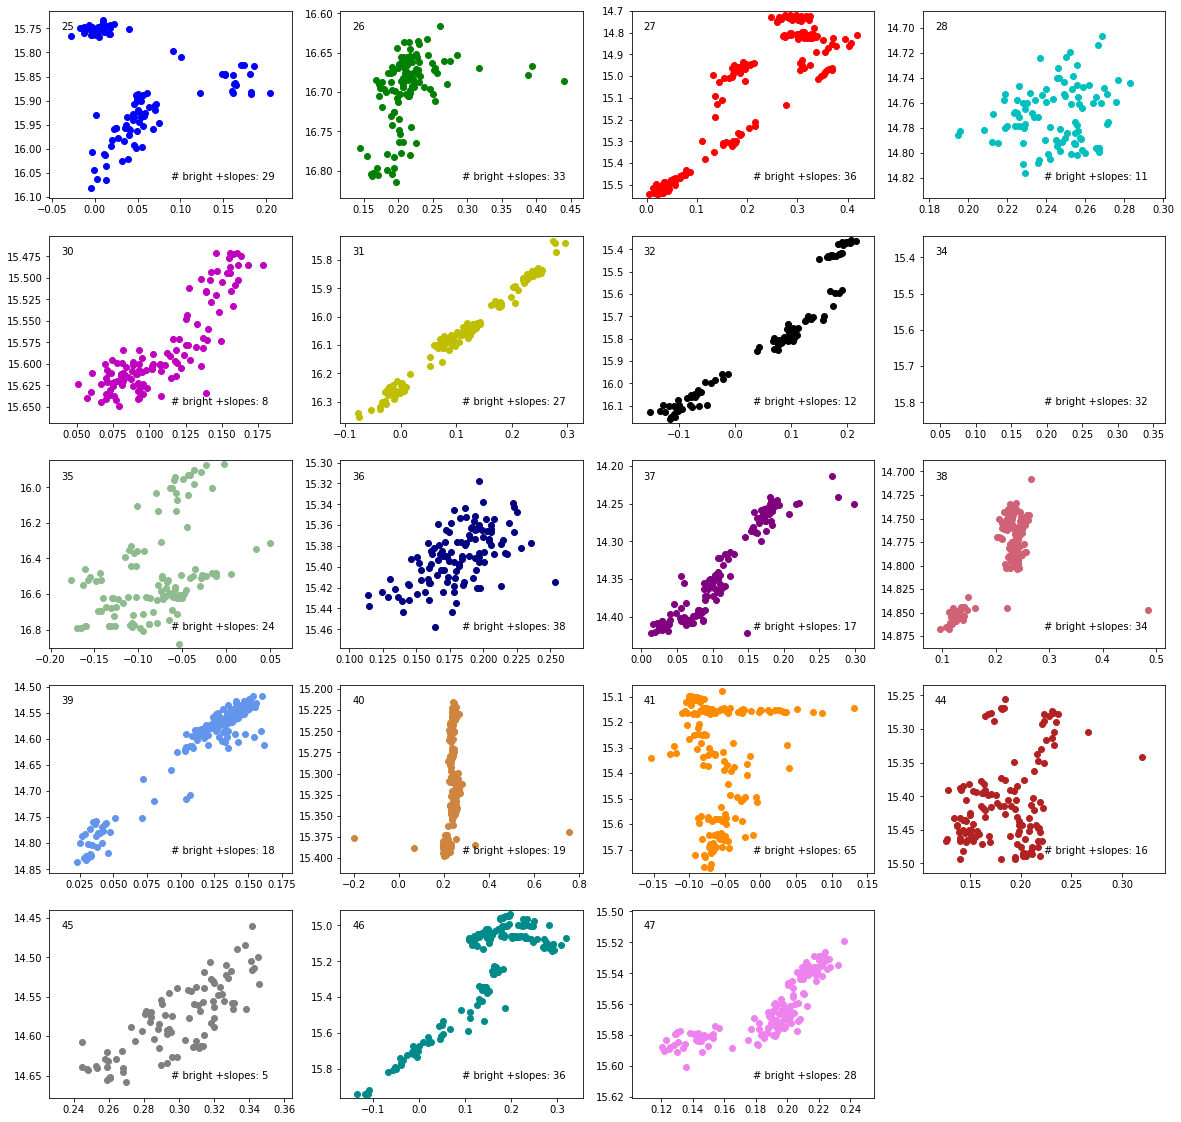

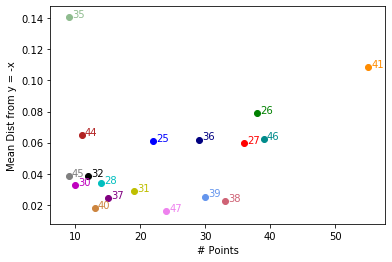

In [19]:
check_quad(srcns[20:40])

#### list of loops -- revisit with arrows
- 3,27

#### potential loops
- 13,4,6 (and these don't stick out on plot very well)
    - these would do better with just looking for higher spread at brighter values
- 46, 25
    
#### list of other strange sources to revisit with arrows
- 11,16 (are these "loops"?)
- 41 (high up on all metrics)
- 35 (only high on dist from y = -x)

In [21]:
#get rid of source #51
srcns = list(srcns)
srcns.remove(51)

In [22]:
srcns.remove(1) #no source

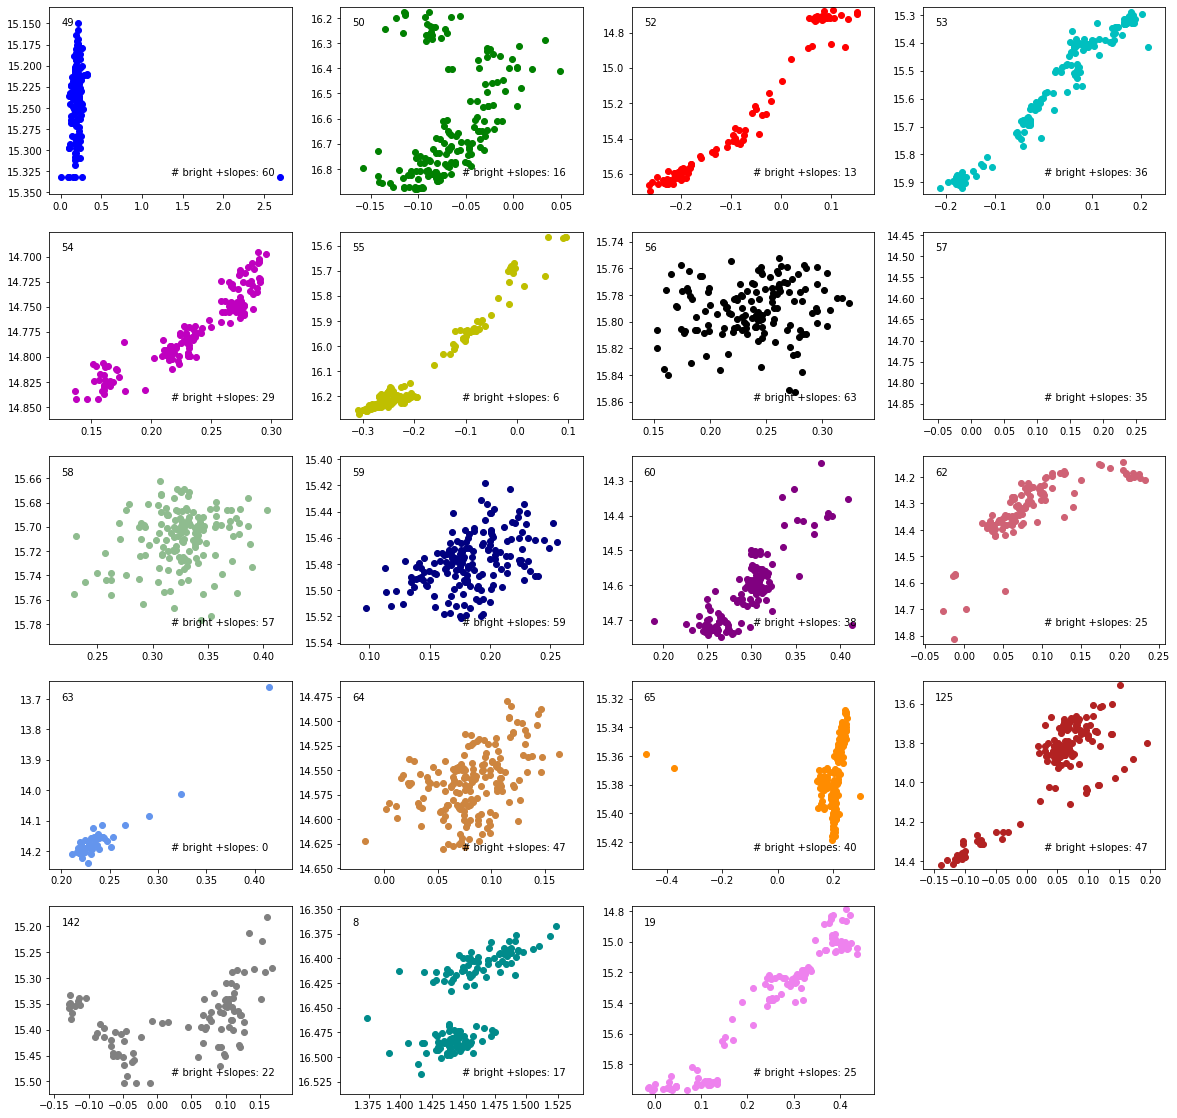

posx and posy should be finite values
posx and posy should be finite values


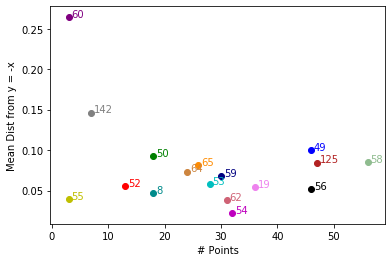

In [23]:
#continuing with next 20 sources (without #51)
check_quad(srcns[40:60])

to do: check why some not plotted (e.g. src #57)

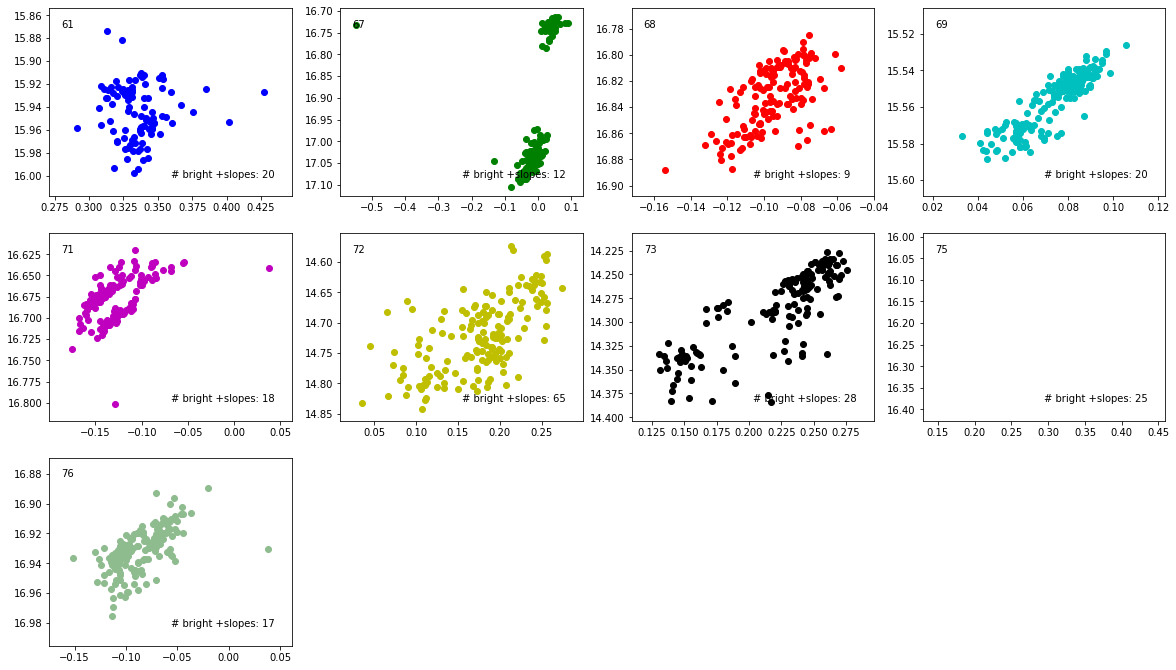

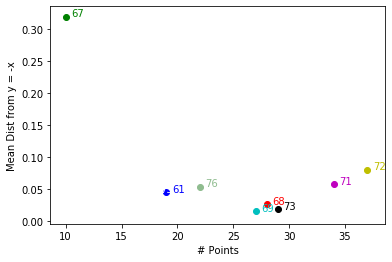

In [26]:
check_quad(srcns[60:70])

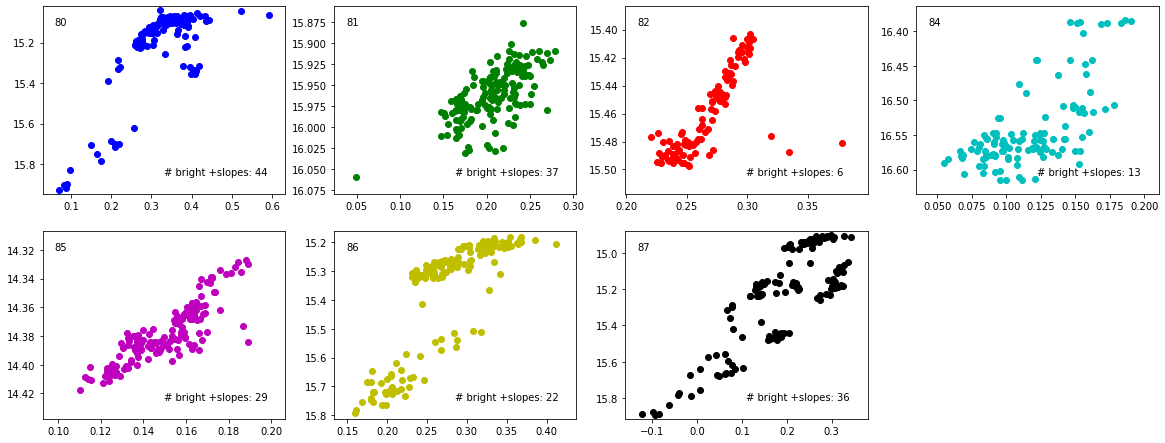

posx and posy should be finite values
posx and posy should be finite values


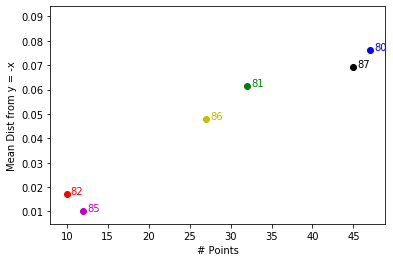

In [28]:
check_quad(srcns[72:80])

empty file for OIII I


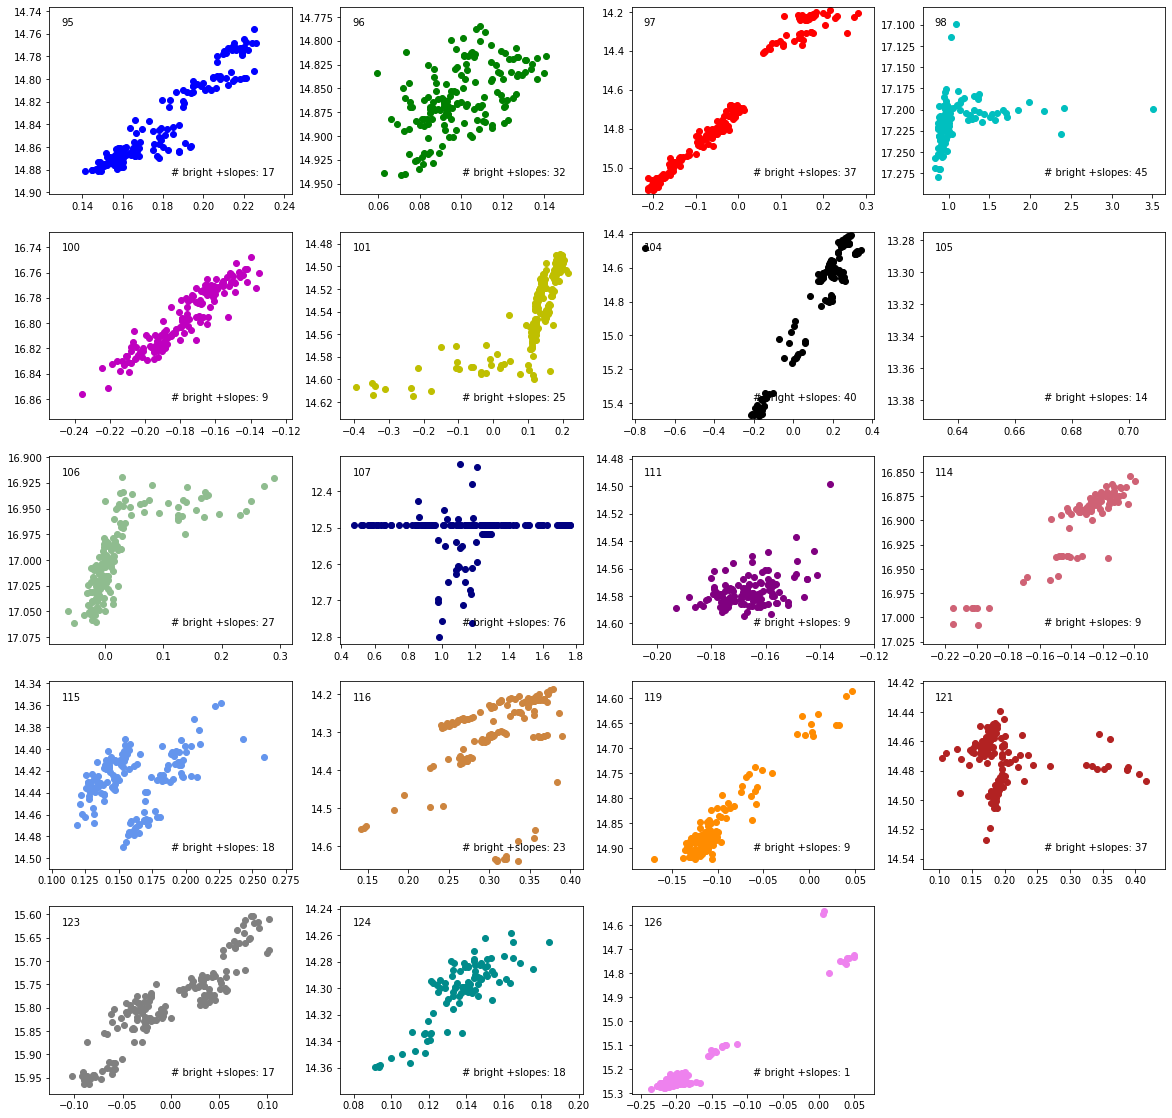

posx and posy should be finite values
posx and posy should be finite values


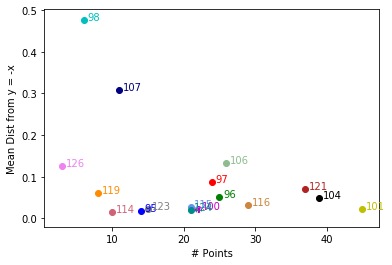

In [29]:
check_quad(srcns[80:100])

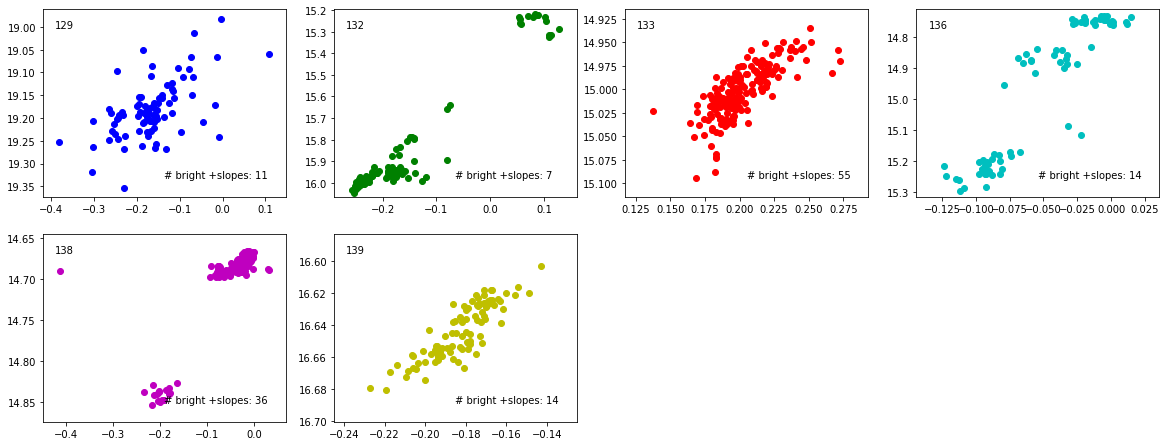

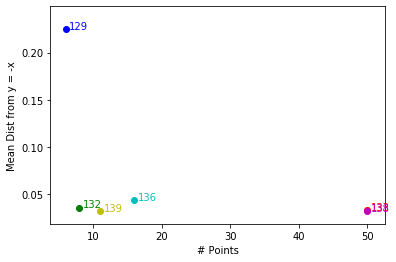

In [30]:
check_quad(srcns[100:])